## Install modules

In [0]:
!pip3 install dalex

## Get data

In [0]:
!wget http://students.mimuw.edu.pl/~wd393711/iml/hotel-booking-demand.zip
!unzip -o hotel-booking-demand.zip

## Some imports

In [0]:
import pandas as pd
import numpy as np
np.random.seed(1)

## Load data

In [0]:
def process_data(data):
    # Indicate if the booking was made by a company
    data['has_company'] = data['company'].isnull()
    data = data.drop(columns='company')
    # Indicate if the booking was made by an agency
    data['has_agent'] = data['agent'].isnull()
    data = data.drop(columns='agent')
    # Encode months as oredered categorical values
    data['arrival_date_month'] = data['arrival_date_month'].astype('category').cat.set_categories(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
    # Drop not used information
    data = data.drop(columns='reservation_status_date')
    # Encode reservation status, custome type, deposit type
    data = pd.get_dummies(data, columns=['reservation_status', 'customer_type', 'deposit_type', 'market_segment', 'distribution_channel', 'meal'])
    # Encode difference in room type
    data['got_higher_type_room'] = data['reserved_room_type'] > data['assigned_room_type']
    data['got_lower_type_room'] = data['reserved_room_type'] < data['assigned_room_type']
    data['reserved_room_type'] = data['reserved_room_type'].astype('category')
    data['assigned_room_type'] = data['assigned_room_type'].astype('category')
    # Treat counties as categorial data
    data = data.drop(columns=['country'])
    # Drop hotel name
    data = data.drop(columns='hotel')
    # If children is Nan treat it as 0
    data['children'] = data['children'].fillna(0)
    # Encode categorial data with ints
    categorial_columns = data.select_dtypes(['category']).columns
    data[categorial_columns] = data[categorial_columns].apply(lambda x: x.cat.codes)
    return data

In [0]:
def split_to_test_and_train(data, p=0.1):
    train_mask = np.random.rand(len(data)) < 0.9
    return data[train_mask], data[~train_mask]

y_columns=["is_repeated_guest"]

def split_to_x_y(data, y_columns=y_columns):
    return data.drop(columns=y_columns), data[y_columns]

def get_data(data):
    return (split_to_x_y(ds) for ds in split_to_test_and_train(data))

In [0]:
data = process_data(pd.read_csv("hotel_bookings.csv"))
(train_x, train_y), (test_x, test_y) = get_data(data)

## Simple data analyzys

In [0]:
count_values = data["is_repeated_guest"].value_counts()

In [0]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'number of observations')

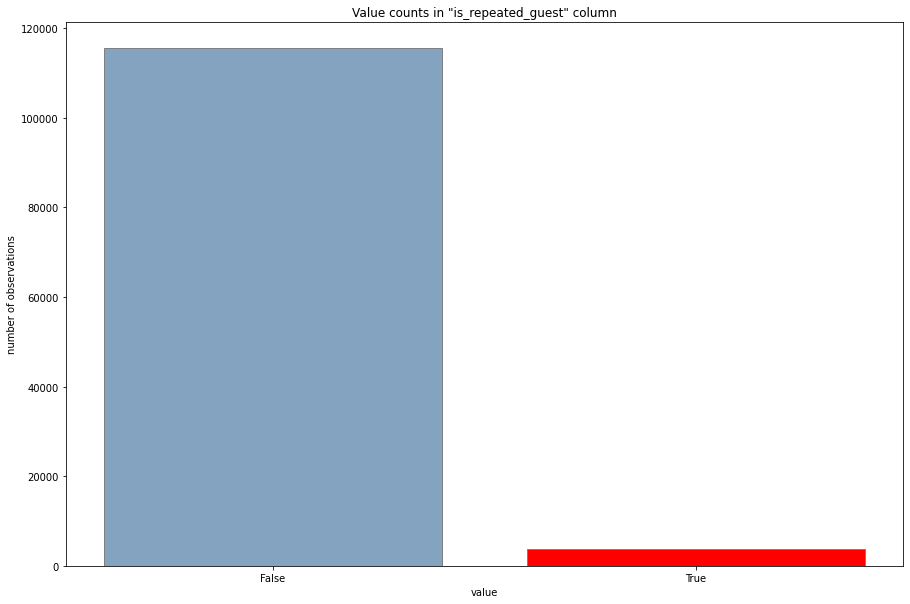

In [9]:
_ = plt.figure(figsize=(15,10))
plt.bar(['False', 'True'], count_values.values, color=[(0.2, 0.4, 0.6, 0.6), 'red'],  edgecolor='grey')
plt.title("Value counts in \"is_repeated_guest\" column")
plt.xlabel('value')
plt.ylabel('number of observations')

## Create models

In [0]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
models = {"XGBClassifier": XGBClassifier(), "XGBClassifier_spw32": XGBClassifier(scale_pos_weight=32.), "XGBClassifier_spw256": XGBClassifier(scale_pos_weight=256.),  "RandomForestClassifier": RandomForestClassifier()}

## Train models

In [11]:
for model_name, model in models.items():
    model.fit(train_x, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


## Evaluate models


In [12]:
# Describe the distribution of the result in the test dataset
pd.DataFrame(test_y).describe()

,is_repeated_guest
count,12027.000000
mean,0.035254
std,0.184429
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [13]:
from sklearn.metrics import accuracy_score
models_summary = {name: {"train_accuracy": accuracy_score(train_y, model.predict(train_x)),
                         "test_accuracy": accuracy_score(test_y, model.predict(test_x)),
                         "test_wrong_answer_distribution": test_y[model.predict(test_x) != test_y.values]['is_repeated_guest'].value_counts(normalize=True)[1]}
                  for name, model in models.items()}
models_summary['base'] = {"train_accuracy": 0.,
                         "test_accuracy": 0.,
                         "test_wrong_answer_distribution": test_y['is_repeated_guest'].value_counts(normalize=True)[1] }
for name, summary in models_summary.items():
    print("model:", name, "\n",
          "\ttrain acc:", summary["train_accuracy"], "\n"
          "\ttest acc:", summary["test_accuracy"], "\n"
          "\tmean value of the wrong answer for prediction on the test part:", summary["test_wrong_answer_distribution"])

model: XGBClassifier 
 	train acc: 0.9904529493400892 
	test acc: 0.9904381807599567 
	mean value of the wrong answer for prediction on the test part: 0.48863316767387155
model: XGBClassifier_spw32 
 	train acc: 0.9636932649050418 
	test acc: 0.9612538455142596 
	mean value of the wrong answer for prediction on the test part: 0.32017023554473467
model: XGBClassifier_spw256 
 	train acc: 0.90334659053864 
	test acc: 0.9017211274632078 
	mean value of the wrong answer for prediction on the test part: 0.1923378245605731
model: RandomForestClassifier 
 	train acc: 0.9997950876931532 
	test acc: 0.9920179595909204 
	mean value of the wrong answer for prediction on the test part: 0.49515468976236343
model: base 
 	train acc: 0.0 
	test acc: 0.0 
	mean value of the wrong answer for prediction on the test part: 0.035254011806768105


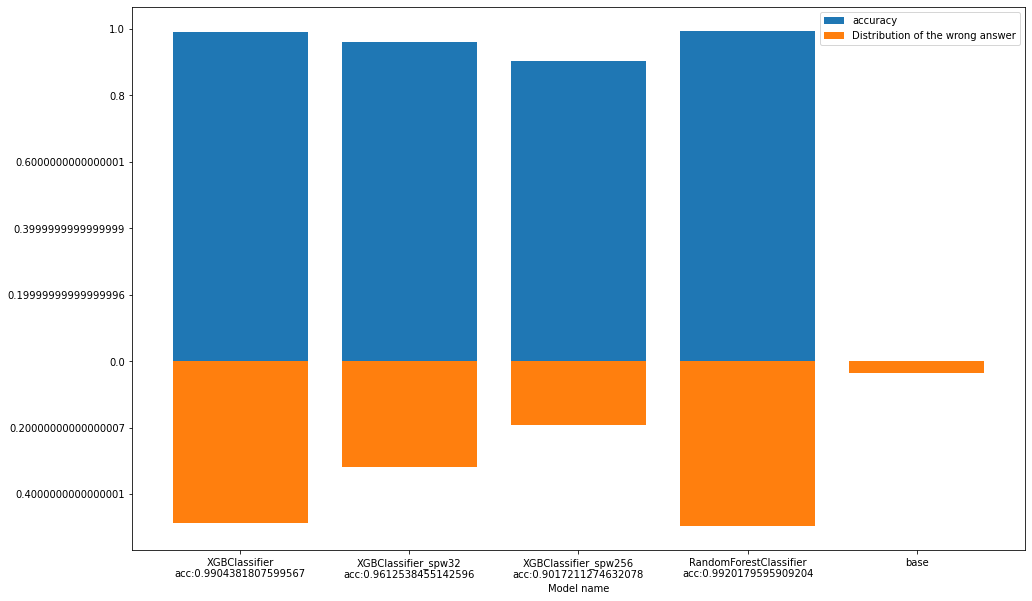

In [14]:
fig, ax = plt.subplots(figsize=(16,10))
labels = list(map(lambda name_summary: name_summary[0] if name_summary[0] == 'base' else name_summary[0] + "\nacc:" + str(name_summary[1]['test_accuracy']), models_summary.items()))
ax.bar(labels, list(map(lambda summary: summary['test_accuracy'], models_summary.values())), label="accuracy")
ax.bar(labels, list(map(lambda summary: (-1)* summary['test_wrong_answer_distribution'], models_summary.values())), label="Distribution of the wrong answer")

# Formatting x labels
plt.xlabel('Model name')
plt.legend()
# Use absolute value for y-ticks
ticks =  ax.get_yticks()
ax.set_yticklabels([abs(tick) for tick in ticks])

plt.show()

## Explaining

In [0]:
from dalex import Explainer

In [16]:
explainers = {name: Explainer(model=model, data=test_x, y=test_y['is_repeated_guest'], model_type='classifier') for name, model in models.items()}

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 12027 rows 52 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12027 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x7fa6a73f07b8> will be used
  -> predicted values  : min = 0.00011373791, mean = 0.03464703, max = 0.9800724
  -> residual function : difference between y and yhat
  -> residuals         : min = -0.9698466658592224, mean = 0.0006069812928060677, max = 0.9990989684010856
  -> model_info        : package xgboost

A new explainer has been created!
Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 12027 rows 52 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12027 values
  -> predict functi

In [0]:
def explain(x, explainer):
    # Shap
    #shap = explainer.predict_parts(x, type='shap')
    #shap.plot()

    # Break Down
    break_down = explainer.predict_parts(test_x.loc[x].astype('float'), type='break_down')
    break_down.plot()

In [0]:
def explain_all(x):
    for explainer in explainers.values():
        explain(x, explainer)

In [19]:
explain(14855, explainers['XGBClassifier'])
explain(14855, explainers['XGBClassifier_spw256'])

In [22]:
explain(21, explainers['XGBClassifier'])
explain(21, explainers['XGBClassifier_spw256'])